# Validate features 
# Validate model prediction

In [2]:
#explore different features for conversation booking rate prediction
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import pylab as pl
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import analytics_lib
from analytics_lib import Bucket_BR_Plot
from analytics_lib.add_column import add_column
import modeldata
from modeldata.importdata import *
from analytics_lib.GenerateCBRCI import GenerateCBRCI
from analytics_lib.EvalLRModel import EvalLRModel
from analytics_lib.model_display_suite import display_model_coef
from analytics_lib.Bucket_BR_Plot import Bucket_BR_Plot
plt.style.use('seaborn')
from IPython.display import display, HTML
from analytics_lib.import_training_data import get_data

In [3]:
data_dir = '/Users/wendyshi/Development/EVS_Data'
date_stamp = '2017-11-28'

In [4]:
evs_hash_sql = '''-- Get nodes & tags for a particular node class
select distinct
  result_node_identity_hash as node_hash
, nd.class as node
, result_tags_identity_hash as tags_hash
, tg.tags as tags
from
searchscore_components.dependency_graph dg
join searchscore_components.node nd on
  nd.run_uuid = dg.run_uuid
  and nd.identity_hash = dg.result_node_identity_hash
join searchscore_components.ss_tag tg on
  tg.run_uuid = dg.run_uuid
  and tg.identity_hash = dg.result_tags_identity_hash
where
nd.class like '%%ExpectedValueSearchScore'
and dg.run_date = 'update_date'
;'''
evs_hash = get_data(filename='evs_hash.csv',data_dir=data_dir,force_download=True,sql=evs_hash_sql,update_date = date_stamp)
display(evs_hash)


r2b_hash_sql = '''-- Get nodes & tags for a particular node class
select distinct
  result_node_identity_hash as node_hash
, nd.class as node
, result_tags_identity_hash as tags_hash
, tg.tags as tags
from
searchscore_components.dependency_graph dg
join searchscore_components.node nd on
  nd.run_uuid = dg.run_uuid
  and nd.identity_hash = dg.result_node_identity_hash
join searchscore_components.ss_tag tg on
  tg.run_uuid = dg.run_uuid
  and tg.identity_hash = dg.result_tags_identity_hash
where
nd.class like '%%RequestToBookLogisticRegressionByServiceTypeAndMatriculationLevel'
and dg.run_date = 'update_date'
;'''
r2b_hash = get_data(filename='r2b_hash.csv',data_dir=data_dir,force_download=True,sql=r2b_hash_sql,update_date = date_stamp)
display(r2b_hash)

-- Get nodes & tags for a particular node class
select distinct
  result_node_identity_hash as node_hash
, nd.class as node
, result_tags_identity_hash as tags_hash
, tg.tags as tags
from
searchscore_components.dependency_graph dg
join searchscore_components.node nd on
  nd.run_uuid = dg.run_uuid
  and nd.identity_hash = dg.result_node_identity_hash
join searchscore_components.ss_tag tg on
  tg.run_uuid = dg.run_uuid
  and tg.identity_hash = dg.result_tags_identity_hash
where
nd.class like '%%ExpectedValueSearchScore'
and dg.run_date = '2017-11-28'
;
downlaoded data


,node_hash,node,tags_hash,tags
0,5000f1ac5901778fa4bc671147ea0157ec42cb46,search_scores.expected_value.expected_value_se...,bace3c51312e7da6dfd0846dbc4962b5ce1a50f8,expected_value_search_score=true


-- Get nodes & tags for a particular node class
select distinct
  result_node_identity_hash as node_hash
, nd.class as node
, result_tags_identity_hash as tags_hash
, tg.tags as tags
from
searchscore_components.dependency_graph dg
join searchscore_components.node nd on
  nd.run_uuid = dg.run_uuid
  and nd.identity_hash = dg.result_node_identity_hash
join searchscore_components.ss_tag tg on
  tg.run_uuid = dg.run_uuid
  and tg.identity_hash = dg.result_tags_identity_hash
where
nd.class like '%%RequestToBookLogisticRegressionByServiceTypeAndMatriculationLevel'
and dg.run_date = '2017-11-28'
;
downlaoded data


,node_hash,node,tags_hash,tags
0,e5f66df669fc2c467feb06e7e66fdf96d8ba0344,search_scores.expected_value.request_to_book.R...,f9065fa7389750e16fe00d7ba36748f61d3e0df6,


In [5]:
evs_convo_sql = '''
with
  final_seg as (
    select
      epeg.person_id
      , epeg.group as label
      , added as seg_added
    from
      roverdb.experiments_personexperimentgroup epeg
    where
      experiment_slug = 'multi-split-search-scores-experiment-11072017'
  )
select
  cc.id as conversation_id
  , cc.added as cc_added
  , cc.service_type
  , cc.is_repeat_customer
  , cc.has_stay
  , cc.requester_id
  , nn.requester_was_new_customer
  , nn.added as need_added
  , nn.id as need_id
  , cc.service_id
  , person_type
  , case
    when mc.id is null
      then 0
    else 1
  end as come_from_search
  , r2b.result as r2b
  , evs.result as evs
  , fs.label
from
  roverdb.conversations_conversation cc
  join roverdb.needs_need nn on
    nn.id = cc.need_id
  join final_seg fs on
    fs.person_id = cc.requester_id
  join rover.person_import_type pit on
    pit.person_id = cc.provider_id
  join search_score_components_results.result evs on
    evs.run_date = date(cc.added)
    and evs.node_identity_hash = 'evs_node_hash'
    and evs.tags_identity_hash = 'evs_tags_hash'
    and evs.service_id = cc.service_id
  join search_score_components_results.result r2b on
    r2b.run_date = date(cc.added)
    and r2b.node_identity_hash = 'r2b_node_hash'
    and r2b.tags_identity_hash = 'r2b_tags_hash'
    and r2b.service_id = cc.service_id
  left join pganalytics.megatron_searcheventconversation mc on
    cc.id = mc.conversation_id
where
  cc.service_type <> 'on-demand-dog-walking'
  and cc.added >= seg_added
  and cc.added >= 'update_date'
  
'''
evs_convo_sql = evs_convo_sql.replace('r2b_node_hash',r2b_hash.node_hash.to_string().split(' ')[-1]).replace('r2b_tags_hash',r2b_hash.tags_hash.to_string().split(' ')[-1])
evs_convo_sql = evs_convo_sql.replace('evs_node_hash',evs_hash.node_hash.to_string().split(' ')[-1]).replace('evs_tags_hash',evs_hash.tags_hash.to_string().split(' ')[-1])
evs_convo = get_data(force_download=True,filename='evs_convo.csv',data_dir=data_dir,update_date=date_stamp,sql = evs_convo_sql)


with
  final_seg as (
    select
      epeg.person_id
      , epeg.group as label
      , added as seg_added
    from
      roverdb.experiments_personexperimentgroup epeg
    where
      experiment_slug = 'multi-split-search-scores-experiment-11072017'
  )
select
  cc.id as conversation_id
  , cc.added as cc_added
  , cc.service_type
  , cc.is_repeat_customer
  , cc.has_stay
  , cc.requester_id
  , nn.requester_was_new_customer
  , nn.added as need_added
  , nn.id as need_id
  , cc.service_id
  , person_type
  , case
    when mc.id is null
      then 0
    else 1
  end as come_from_search
  , r2b.result as r2b
  , evs.result as evs
  , fs.label
from
  roverdb.conversations_conversation cc
  join roverdb.needs_need nn on
    nn.id = cc.need_id
  join final_seg fs on
    fs.person_id = cc.requester_id
  join rover.person_import_type pit on
    pit.person_id = cc.provider_id
  join search_score_components_results.result evs on
    evs.run_date = date(cc.added)
    and evs.node_identity_h

In [6]:
fea_hash_sql = '''
select distinct
  result_node_identity_hash as feature_node_hash
  , result_tags_identity_hash as feature_tag_hash
  , class
from
  searchscore_components.dependency_graph dg
  join searchscore_components.node nd on
    dg.result_node_identity_hash = nd.identity_hash
  join searchscore_components.ss_tag tg on
    tg.identity_hash = dg.result_tags_identity_hash
where
  dg.run_date = 'update_date'
  and class like '%%feature%%'
  and nd.run_date = 'update_date'
  and tg.run_date = 'update_date'
'''
fea_hash = get_data(filename='rtb_feature_hash.csv',data_dir=data_dir,force_download=True,sql=fea_hash_sql, update_date = date_stamp)
display(fea_hash)
fea_sql = '''select
  cc.id as conversation_id
  , r.result as feature_result
  , r.column_name as feature_name
from
  roverdb.conversations_conversation cc
  join search_score_components_results.result r on
    r.run_date = date(cc.added)
    and r.node_identity_hash = 'node_hash'
    and r.tags_identity_hash = 'tags_hash'
    and r.service_id = cc.service_id
where
  r.run_date >= 'update_date' 
'''
fea_sql = fea_sql.replace('node_hash',fea_hash.feature_node_hash.to_string().split(' ')[-1]).replace('tags_hash',fea_hash.feature_tag_hash.to_string().split(' ')[-1])
print fea_sql


select distinct
  result_node_identity_hash as feature_node_hash
  , result_tags_identity_hash as feature_tag_hash
  , class
from
  searchscore_components.dependency_graph dg
  join searchscore_components.node nd on
    dg.result_node_identity_hash = nd.identity_hash
  join searchscore_components.ss_tag tg on
    tg.identity_hash = dg.result_tags_identity_hash
where
  dg.run_date = '2017-11-28'
  and class like '%%feature%%'
  and nd.run_date = '2017-11-28'
  and tg.run_date = '2017-11-28'

downlaoded data


,feature_node_hash,feature_tag_hash,class
0,a8ca1735c8bf474faf9a7aff378d196c800c12c8,f9065fa7389750e16fe00d7ba36748f61d3e0df6,search_scores.expected_value.booking_rate_feat...


select
  cc.id as conversation_id
  , r.result as feature_result
  , r.column_name as feature_name
from
  roverdb.conversations_conversation cc
  join search_score_components_results.result r on
    r.run_date = date(cc.added)
    and r.node_identity_hash = 'a8ca1735c8bf474faf9a7aff378d196c800c12c8'
    and r.tags_identity_hash = 'f9065fa7389750e16fe00d7ba36748f61d3e0df6'
    and r.service_id = cc.service_id
where
  r.run_date >= 'update_date' 



In [7]:
r2b_fea = get_data(filename='r2b_fea.csv',data_dir=data_dir,force_download=False,sql=fea_sql,update_date=date_stamp)

used cached data


In [8]:
r2b_fea_df = pd.pivot_table(r2b_fea, values='feature_result',
                  columns=['feature_name'],index = 'conversation_id')
r2b_fea_df = r2b_fea_df.reset_index()

In [9]:
matriculation_level_hash_sql = '''-- Get nodes & tags for a particular node class
select distinct
  result_node_identity_hash as node_hash
, nd.class as node
, result_tags_identity_hash as tags_hash
, tg.tags as tags
from
searchscore_components.dependency_graph dg
join searchscore_components.node nd on
  nd.run_uuid = dg.run_uuid
  and nd.identity_hash = dg.result_node_identity_hash
join searchscore_components.ss_tag tg on
  tg.run_uuid = dg.run_uuid
  and tg.identity_hash = dg.result_tags_identity_hash
where
nd.class like '%%ServiceMatriculationLevel'
and dg.run_date = 'update_date'
;'''
matriculation_level_hash = get_data(filename='matriculation_level_hash.csv',data_dir=data_dir,force_download=True,sql=matriculation_level_hash_sql,update_date = date_stamp)
display(matriculation_level_hash)

matriculation_level_sql = '''select
  cc.id as conversation_id
  , r.result as matriculation_level
from
  roverdb.conversations_conversation cc
  join search_score_components_results.result r on
    r.run_date = date(cc.added)
    and r.node_identity_hash = 'node_hash'
    and r.tags_identity_hash = 'tags_hash'
    and r.service_id = cc.service_id
where
  r.run_date >= 'update_date'
'''
matriculation_level_sql = matriculation_level_sql.replace('node_hash',matriculation_level_hash.node_hash.to_string().split(' ')[-1]).replace('tags_hash',matriculation_level_hash.tags_hash.to_string().split(' ')[-1])
print matriculation_level_sql

-- Get nodes & tags for a particular node class
select distinct
  result_node_identity_hash as node_hash
, nd.class as node
, result_tags_identity_hash as tags_hash
, tg.tags as tags
from
searchscore_components.dependency_graph dg
join searchscore_components.node nd on
  nd.run_uuid = dg.run_uuid
  and nd.identity_hash = dg.result_node_identity_hash
join searchscore_components.ss_tag tg on
  tg.run_uuid = dg.run_uuid
  and tg.identity_hash = dg.result_tags_identity_hash
where
nd.class like '%%ServiceMatriculationLevel'
and dg.run_date = '2017-11-28'
;
downlaoded data


,node_hash,node,tags_hash,tags
0,1195b068e4c4e9ec0858746f0d527658eebb13b3,search_scores.expected_value.matriculation_lev...,f9065fa7389750e16fe00d7ba36748f61d3e0df6,


select
  cc.id as conversation_id
  , r.result as matriculation_level
from
  roverdb.conversations_conversation cc
  join search_score_components_results.result r on
    r.run_date = date(cc.added)
    and r.node_identity_hash = '1195b068e4c4e9ec0858746f0d527658eebb13b3'
    and r.tags_identity_hash = 'f9065fa7389750e16fe00d7ba36748f61d3e0df6'
    and r.service_id = cc.service_id
where
  r.run_date >= 'update_date'



In [10]:
matriculation_level = get_data(filename='matriculation_level.csv',data_dir=data_dir,force_download=False,sql=matriculation_level_sql,update_date = date_stamp)
r2b_fea_df = r2b_fea_df.merge(matriculation_level,on='conversation_id')

used cached data


In [11]:
base_query = '''select
  cc.id as conversation_id
  , cc.added as conversation_added
  , cc.service_type
  , cc.ignore_from_search_reason
  , cc.is_premier as convo_is_premier
  , cc.is_repeat_customer
  , cc.provider_id
  , nn.requester_was_new_customer
  , case
    when nn.booked_stay_count > 0
      then 1
    else 0
  end as need_booked
  , cc.has_stay as booked
  , ss.added as booked_time
from
  roverdb.conversations_conversation cc
  join roverdb.needs_need nn on
    cc.need_id = nn.id
    and nn.is_imported is false
  left join roverdb.stays_stay ss on
    cc.id = ss.conversation_id
where
  cc.added >= 'update_date'
'''

In [12]:
nbs_query = '''
select
  cc.id as conversation_id
  , service_type
  , cc.is_repeat_customer
  , requester_was_new_customer
  , ignore_from_search_reason
  , cc.is_premier as convo_is_premier
  , nbs.*
from
  roverdb.conversations_conversation cc
  join roverdb.needs_need nn on
    cc.need_id = nn.id
    and nn.is_imported is false
  left join roverdb.search_nbsvariantrawdata nbs on
    cc.service_id = nbs.service_id
where
  cc.added >= 'update_date'
'''

In [13]:
recent_booking_sql = '''
with
  base as (
    select
      service_id
      , cc.id as conversation_id
      , has_stay as booked
      , row_number() over(partition by cc.service_id order by cc.added desc, cc.id desc) as recency
      , first_value(cc.id) over(partition by cc.service_id order by cc.added asc rows between unbounded preceding and unbounded following) as first_service_convo
      , case
        when overall is null and has_stay= 1
          then 0.85
        when overall >= 4
          then 1.0
        when overall = 3
          then 0.5
        else 0.0
      end as weight
      ,cc.added
    from
      roverdb.conversations_conversation cc
      left join roverdb.stays_providerrating sp on
        sp.conversation_id = cc.id
      left join roverdb.imports_importedrecord iir on iir.object_id = cc.id and iir.content_type_id = 31 
      and iir.source_name ~ 'dogvacay'
    where
      cc.ignore_from_search_reason is null and cc.is_repeat_customer = 0 and iir.object_id is null and cc.is_premier = 0
    group by
      1
      , 2
      , 3
      , 6
      , cc.added
  )
select
  base.*
  , first.weight as first_weight
  , second.weight as second_weight
  , third.weight as third_weight
  , first.booked as first_booking
  , second.booked as second_booking
  , third.booked as third_booking
from
  base
  left join base first on
  base.service_id = first.service_id
  and base.recency = first.recency - 1
left join base second on
second.service_id = first.service_id
and first.recency = second.recency - 1
left join base third on
third.service_id = first.service_id
and second.recency = third.recency - 1
where base.added >= 'update_date'
'''

In [14]:
providercbr_query= '''
with
  target_conversations as (
    select distinct
      id as conversation_id
    from
      roverdb.conversations_conversation
    where
      added >= 'update_date'
      and service_type <> 'on-demand-dog-walking'
  )
  , target_providers as (
    select distinct
      provider_id
    from
      target_conversations tc
      join roverdb.conversations_conversation cc on
        cc.id = tc.conversation_id
  )
  , first_stays as (
    select
      conversation_id
      , added as first_stay_added
    from
      roverdb.stays_stay
  )
  , unfiltered_all_conversations as (
    select
      tc.*
      , cc2.id as past_conversation_id
    from
      target_conversations tc
      join roverdb.conversations_conversation cc on
        cc.id = tc.conversation_id
      left join roverdb.conversations_conversation cc2 on
        (cc2.added < dateadd(day,-3,cc.added) or (cc2.added < cc.added and cc2.has_stay=1))
        and cc2.provider_id = cc.provider_id
        and cc2.is_premier = 0
      left join first_stays fs on
        fs.conversation_id = cc2.id
      where
      cc2.service_type <> 'on-demand-dog-walking' and
        ( 
          (cc2.ignore_from_search_reason is null)
          or (
            fs.first_stay_added < cc.added
            and cc2.ignore_from_search_reason in (
              'duplicate_conversation'
              , 'repeat_only'
              , 'sitter_unavailable'
              , 'sitter_unavailable_manual'
              , 'pet_not_accepted'
              , 'spay_neuter_status'
              , 'sitter_away'
              , 'requester_deactivated'
              , 'outside_service_radius'
              , 'recurring_billing'
              , 'beyond_calendar_limits'
            )
          )
        )
  )
  , pre_conversations_window1 as (
    select
      uac.*
      , row_number() over(partition by uac.conversation_id, cc.requester_id order by cc.added desc, cc.id desc) as pre_recency
      , cc.requester_id
    from
      unfiltered_all_conversations uac
      join roverdb.conversations_conversation cc on
        cc.id = uac.past_conversation_id
        and cc.is_repeat_customer = 0
  )
  , conversations_window as (
    select
      pcw.conversation_id
      , pcw.requester_id
      , row_number() over(partition by pcw.conversation_id order by cc.added desc, cc.id desc) as recency
    from
      pre_conversations_window1 pcw
      join roverdb.conversations_conversation cc on
        cc.id = pcw.past_conversation_id
    where
      pre_recency = 1
  )
  , raw_stays as (
    select
      s.id as prior_stay_id
      , cc.id as prior_conversation_id
      , cc.service_id
      , cc.provider_id
      , cc.requester_id
      , s.added as prior_stay_added
      , cc.service_type
    from
      roverdb.stays_stay s
      join roverdb.conversations_conversation cc on
        cc.id = s.conversation_id
      join target_providers ts on
        ts.provider_id = cc.provider_id
    where
      s.status <> 'cancelled'
      and cc.is_premier = 0
      and cc.service_type <> 'on-demand-dog-walking'
      and (
        (cc.ignore_from_search_reason is null)
        or (
          cc.ignore_from_search_reason in (
            'duplicate_conversation'
            , 'repeat_only'
            , 'sitter_unavailable'
            , 'sitter_unavailable_manual'
            , 'pet_not_accepted'
            , 'spay_neuter_status'
            , 'sitter_away'
            , 'requester_deactivated'
            , 'outside_service_radius'
            , 'recurring_billing'
            , 'beyond_calendar_limits'
          )
        )
      )
  )
  , recent_reviews as (
    select distinct
      tc.conversation_id
      , rs.requester_id
      , first_value(overall) over(partition by tc.conversation_id, rs.service_id, rs.requester_id order by spr.added desc, spr.id desc rows between unbounded preceding and unbounded following) as overall
      , rs.service_type
    from
      target_conversations tc
      join roverdb.conversations_conversation cc on
        cc.id = tc.conversation_id
      left join raw_stays rs on
        rs.prior_stay_added < cc.added
        and rs.provider_id = cc.provider_id
      left join roverdb.stays_providerrating spr on
        spr.conversation_id = rs.prior_conversation_id
        and spr.poster_id = cc.requester_id
        and spr.added < cc.added
  )
  -- SERVICE_TYPE_CHOICES.walking: [0.98, 0.0, 0.0, 0.10, 0.80, 1.0],
  -- SERVICE_TYPE_CHOICES.day_care: [0.87, 0.0, 0.0, 0.20, 0.42, 1.0],
  --            SERVICE_TYPE_CHOICES.drop_in: [0.94, 0.0, 0.0, 0.25, 0.52, 1.0],
  --            SERVICE_TYPE_CHOICES.boarding: [0.67, 0.0, 0.0, 0.10, 0.53, 1.0],
  --            SERVICE_TYPE_CHOICES.traveling: [0.69, 0.0, 0.0, 0.10, 0.59, 1.0],
  , recent_weights as (
    select
      *
      , case
        when service_type = 'dog-walking'
        and overall is null
          then 0.98
        when service_type = 'dog-walking'
        and overall = 5
          then 1.0
        when service_type = 'dog-walking'
        and overall = 4
          then 0.8
        when service_type = 'dog-walking'
        and overall = 3
          then 0.1
        when service_type = 'doggy-day-care'
        and overall is null
          then 0.87
        when service_type = 'doggy-day-care'
        and overall = 5
          then 1.0
        when service_type = 'doggy-day-care'
        and overall = 4
          then 0.42
        when service_type = 'doggy-day-care'
        and overall = 3
          then 0.2
        when service_type = 'drop-in'
        and overall is null
          then 0.94
        when service_type = 'drop-in'
        and overall = 5
          then 1.0
        when service_type = 'drop-in'
        and overall = 4
          then 0.52
        when service_type = 'drop-in'
        and overall = 3
          then 0.25
        when service_type = 'overnight-boarding'
        and overall is null
          then 0.67
        when service_type = 'overnight-boarding'
        and overall = 5
          then 1.0
        when service_type = 'overnight-boarding'
        and overall = 4
          then 0.53
        when service_type = 'overnight-boarding'
        and overall = 3
          then 0.1
        when service_type = 'overnight-traveling'
        and overall is null
          then 0.69
        when service_type = 'overnight-traveling'
        and overall = 5
          then 1.0
        when service_type = 'overnight-traveling'
        and overall = 4
          then 0.59
        when service_type = 'overnight-traveling'
        and overall = 3
          then 0.1
        else 0.0
      end as weight
    from
      recent_reviews
  )
  , raw_data as (
    select
      cw.conversation_id
      , cw.requester_id
      , cw.recency
      , coalesce(rw.weight, 0.0) as weight
    from
      conversations_window cw
      left join recent_weights rw using (conversation_id, requester_id)
    union all
    select
      tc.conversation_id
      , null as requester_id
      , 0 as recency
      , 0.0 as weight
    from
      target_conversations tc
    where
      tc.conversation_id not in (
        select distinct
          conversation_id
        from
          pre_conversations_window1
      )
  )
select
  conversation_id
  , count(distinct requester_id) as unique_requests_count
  , sum(coalesce(weight, 0.0)) as adj_unique_bookings_count
  , count(
    distinct case
      when recency <= 30
        then requester_id
      else null
    end
  )
  as unique_requests_count_window
  , sum(
    case
      when recency <= 30
        then coalesce(weight, 0.0)
      else 0.0
    end
  )
  as adj_unique_bookings_count_window
from
  raw_data
group by
  1;
'''

In [15]:
calendar_sql = '''select
  cc.id as conversation_id
  , sh.accepts_more_than_one_client
  , sh.last_updated_calendar
  , sh.spaces_available
  , cc.added as conversation_added
from
  roverdb.conversations_conversation cc
  join(
    select distinct
      original_conversation_id
      , accepts_more_than_one_client
      , last_updated_calendar
      , spaces_available
      , service_id
    from
      roverdb_historical.service_history
  )
  sh on
    sh.original_conversation_id = cc.id
    and cc.service_id = sh.service_id
where
  cc.added >= 'update_date';
 ;'''

In [16]:
responsiveness_sql = '''
with
  base as (
    select
      c.id as conversation_id
      , c.provider_id
      , c.service_type
      , c.need_id
      , c.added as conversation_added
      , case
        when c.provider_first_response_seconds is null
          then 0
        else 1
      end as provider_response
      , cm.message_added as first_provider_message_added
      , c.provider_first_response_seconds
    from
      roverdb.conversations_conversation c
      left join (
        select
          sender_id
          , conversation_id
          , min(added) as message_added
        from
          roverdb.conversations_message
        group by
          1
          , 2
      )
      cm on
        cm.sender_id = c.provider_id
        and cm.conversation_id = c.id
  )

,sitter_response as (
select
  b1.conversation_id
  , avg(b2.provider_first_response_seconds) as avg_sitter_response_seconds
  , avg(b2.provider_response*1.00) as sitter_response_pct
from
  base b1
  left join base b2 on
    b1.provider_id = b2.provider_id
    and b1.conversation_added > b2.conversation_added
group by
  1
  )

,service_response as (
  select
  b1.conversation_id
  , avg(b2.provider_first_response_seconds) as avg_service_response_seconds
  , avg(b2.provider_response*1.00) as service_response_pct
from
  base b1
  left join base b2 on
    b1.provider_id = b2.provider_id
    and b1.service_type = b2.service_type
    and b1.conversation_added > b2.conversation_added
group by
  1
  )

select
base.conversation_id
,base.provider_response
,base.provider_first_response_seconds
,sitter_response.avg_sitter_response_seconds
,sitter_response.sitter_response_pct
,service_response.avg_service_response_seconds
,service_response.service_response_pct
from
base
left join sitter_response on
  base.conversation_id = sitter_response.conversation_id
left join service_response on
  base.conversation_id = service_response.conversation_id
where base.conversation_added >= 'update_date';
'''

In [17]:
date_stamp

'2017-11-28'

In [18]:
from analytics_lib.import_training_data import get_feature_from_database
df_database = get_feature_from_database(data_dir = data_dir,start_date=date_stamp,force_download=True,purpose ='feature')

getting feature data on or after 2017-11-28
getting dataset for features including all conversations after 2017-11-28
select
  cc.id as conversation_id
  , cc.added as conversation_added
  , cc.service_type
  , cc.ignore_from_search_reason
  , cc.is_premier as convo_is_premier
  , cc.is_repeat_customer
  , cc.provider_id
  , nn.requester_was_new_customer
  , case
    when nn.booked_stay_count > 0
      then 1
    else 0
  end as need_booked
  , cc.has_stay as booked
  , ss.added as booked_time
  , case when search.conversation_id is not null then True else False end as came_from_search
from
  roverdb.conversations_conversation cc
  join roverdb.needs_need nn on
    cc.need_id = nn.id
    and nn.is_imported is false
  left join roverdb.stays_stay ss on
    cc.id = ss.conversation_id
  left join pganalytics.megatron_searcheventconversation search on
  	search.conversation_id = cc.id
where
  cc.added >= '2017-11-28'

downlaoded data

with
  base as (
    select
      service_id
      , cc

downlaoded data
used cached data

with
  base as (
    select
      c.id as conversation_id
      , c.provider_id
      , c.service_type
      , c.need_id
      , c.added as conversation_added
      , case
        when c.provider_first_response_seconds is null
          then 0
        else 1
      end as provider_response
      , cm.message_added as first_provider_message_added
      , c.provider_first_response_seconds
    from
      roverdb.conversations_conversation c
      left join (
        select
          sender_id
          , conversation_id
          , min(added) as message_added
        from
          roverdb.conversations_message
        group by
          1
          , 2
      )
      cm on
        cm.sender_id = c.provider_id
        and cm.conversation_id = c.id
  )

,sitter_response as (
select
  b1.conversation_id
  , avg(b2.provider_first_response_seconds) as avg_sitter_response_seconds
  , avg(b2.provider_response*1.00) as sitter_response_pct
from
  base b1
  left joi

In [ ]:
# def get_feature_from_database(start_date = date_stamp, data_dir=os.getcwd(),filename = 'feature_database.csv'):
#     base = get_data(filename='database_base.csv',data_dir=data_dir,update_date=start_date,sql = base_query)
    
#     recent_booking = get_data(filename='database_recent_booking.csv',data_dir=data_dir,update_date=start_date,sql = recent_booking_sql,force_download=False)
#     for slug in ['first','second','third']:
#         recent_booking[slug+'_booking'] = (recent_booking[slug+'_weight'] > 0)
#         recent_booking[slug+'_request'] = (pd.isnull(recent_booking[slug+'_weight']) == False)
    
#     providercbr = get_data(filename='database_providercbr.csv',data_dir=data_dir,update_date=start_date,sql = providercbr_query,force_download=True)
#     providercbr.columns = ['conversation_id','provider_all_requests','provider_all_bookings','provider_window_requests','provider_window_bookings']
#     providercbr['provider_cbr_all'] = providercbr['provider_all_bookings'].div(providercbr['provider_all_requests'])

#     calendar = get_data(filename='database_calendar.csv',data_dir=data_dir,update_date=start_date,sql = calendar_sql)
#     calendar['calendar_recency'] = (pd.to_datetime(calendar.conversation_added) - pd.to_datetime(calendar.last_updated_calendar)).dt.days
    
#     responsiveness = get_data(filename='database_responsiveness.csv',data_dir=data_dir,update_date=start_date,sql = responsiveness_sql,force_download=False)
#     responsiveness.loc[pd.isnull(responsiveness.avg_service_response_seconds)==False,'avg_service_response_seconds_decile'] = pd.qcut(responsiveness['avg_service_response_seconds'],10,labels=False)
#     responsiveness.loc[pd.isnull(responsiveness.avg_sitter_response_seconds)==False,'avg_sitter_response_seconds_decile'] = pd.qcut(responsiveness['avg_sitter_response_seconds'],10,labels=False)
    
#     nbs = get_data(filename='database_nbs.csv',data_dir=data_dir,update_date=start_date,sql = nbs_query,engin='roverdb',force_download=False)
#     nbs.columns = [u'conversation_id', u'service_type', u'is_repeat_customer',
#        u'requester_was_new_customer', u'ignore_from_search_reason',
#        u'convo_is_premier', u'id', u'added', u'modified',
#        u'signup_reason', u'expected_earnings', u'available_all_days',
#        u'rover_training', u'lessonly_training', u'background_check_taken',
#        u'has_insurance', u'is_premier', u'num_testimonials', u'relative_price',
#        u'profile_quality', u'facebook_connected', u'num_pets',
#        u'flexible_availability', u'spaces_available', u'small_dogs',
#        u'medium_dogs', u'large_dogs', u'giant_dogs', u'dogs_experience_len',
#        u'description_len', u'num_images', u'avg_testimonial_len',
#        u'avg_image_resolution', u'gender', u'years_of_experience', u'donation',
#        u'app_downloaded', u'verified_by', u'used_rover_to_find_sitter',
#        u'building_type', u'yard_type', u'inspected_home', u'max_dogs',
#        u'service_id']
    
#     df = base.merge(nbs,on='conversation_id')
#     df = base.merge(providercbr,on='conversation_id')
#     df = df.merge(responsiveness, on = 'conversation_id')
#     df = df.merge(recent_booking[['conversation_id','first_booking','second_booking','third_booking','first_request','second_request','third_request']], on = 'conversation_id')
#     df = df.merge(calendar,on='conversation_id')
#     for i in list(df):
#         if '_y' in i:
#             print i
#             df = df.drop(i,axis=1)
#         elif '_x' in i:
#             print i
#             df = df.rename(columns={i:i.replace('_x','')})
#     df = df.loc[:,~df.columns.duplicated()]
    
#     filename = filename.replace('.csv','_'+start_date+'.csv')
#     df.to_csv(os.path.join(data_dir,filename))
    
#     return df

In [ ]:
# df_database = get_feature_from_database(data_dir = data_dir)

In [19]:
df_combo = df_database.merge(r2b_fea_df,suffixes=['_db','_r2b'],on='conversation_id')
df_combo = df_combo.merge(evs_convo,suffixes=['','_convo'],on='conversation_id', how='inner')
for i in list(df_combo):
        if '_y' in i:
            print i
            df_combo = df_combo.drop(i,axis=1)
        elif '_x' in i:
            print i
            df_combo = df_combo.rename(columns={i:i.replace('_x','')})
df_combo = df_combo.loc[:,~df_combo.columns.duplicated()]

rover_imported_ratio_x_cbr


In [20]:
df_combo = df_combo.rename(columns={'matriculation_level':'matriculation_level_r2b'})
df_combo = df_combo.rename(columns={'unique_requests_count':'all_requests_provider'})

In [21]:
from analytics_lib.gen_color_df import gen_color_df
df_combo = gen_color_df(df_combo)
df_combo['matriculation_level_db'] = 3*(df_combo['status']=='red').astype(int) + 2*(df_combo['status']=='green').astype(int) + (df_combo['status']=='seeding').astype(int)

In [23]:
list(df_combo)

[u'conversation_id',
 u'conversation_added',
 u'service_type',
 u'ignore_from_search_reason',
 u'convo_is_premier',
 u'is_repeat_customer',
 u'provider_id',
 u'requester_was_new_customer',
 u'need_booked',
 u'booked',
 u'booked_time',
 u'came_from_search',
 'id',
 'added',
 'modified',
 'signup_reason',
 'expected_earnings',
 'available_all_days',
 'rover_training',
 'lessonly_training',
 'background_check_taken',
 'has_insurance',
 'is_premier',
 'num_testimonials_db',
 'relative_price_db',
 'profile_quality',
 'facebook_connected',
 'num_pets',
 'flexible_availability',
 'spaces_available_db',
 'small_dogs',
 'medium_dogs',
 'large_dogs',
 'giant_dogs',
 'dogs_experience_len',
 'description_len',
 'num_images_db',
 'avg_testimonial_len',
 'avg_image_resolution_db',
 'gender',
 'years_of_experience_db',
 'donation',
 'app_downloaded',
 'verified_by',
 'used_rover_to_find_sitter',
 'building_type',
 'yard_type',
 'inspected_home',
 'max_dogs',
 'service_id',
 u'all_requests_provider',


In [24]:
fea_db = [x for x in list(df_combo) if '_db' in x]
fea_r2b = [x for x in list(df_combo) if '_r2b' in x]

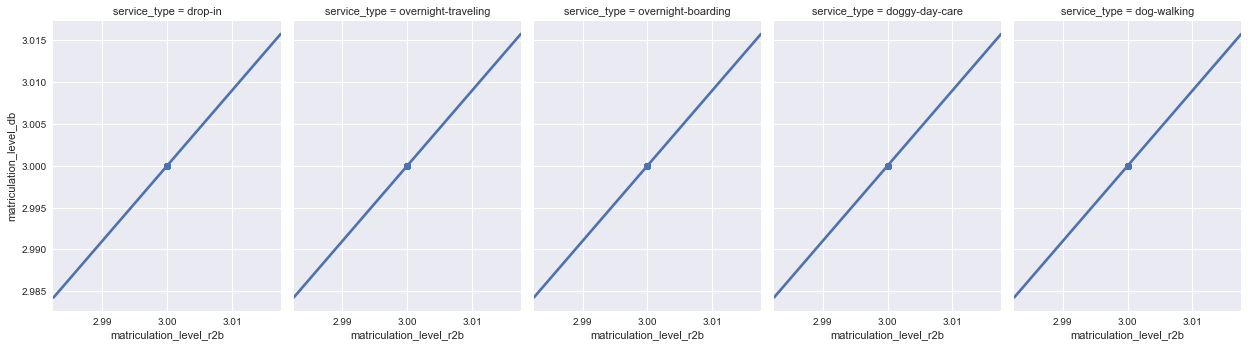

In [27]:
sns.lmplot(x='matriculation_level_r2b', y='matriculation_level_db', col='service_type', data=df_combo[df_combo.matriculation_level_r2b == 3],aspect=0.7,col_wrap=5)
plt.show()

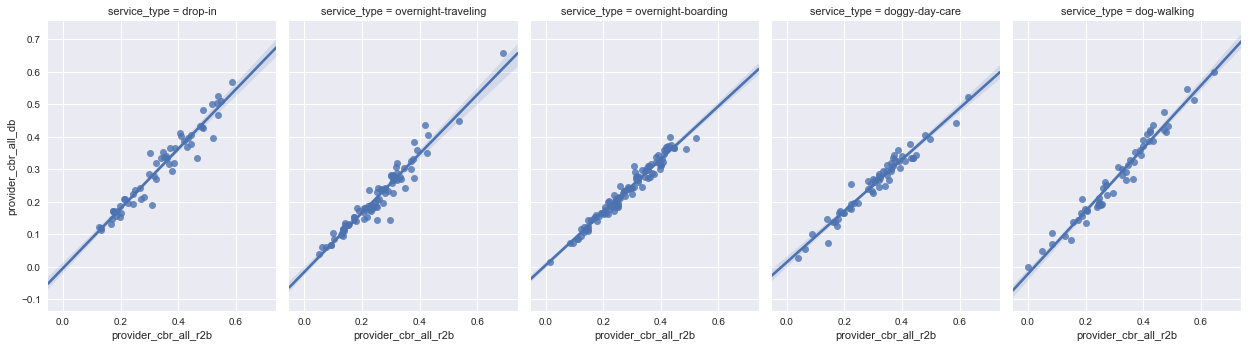

In [26]:
sns.lmplot(x='provider_cbr_all_r2b', y='provider_cbr_all_db', col='service_type', data=df_combo[df_combo.matriculation_level_r2b == 3],aspect=0.7,col_wrap=5)
plt.show()


In [30]:
df_combo['cbr_diff'] = df_combo.provider_cbr_all_db - df_combo.provider_cbr_all_r2b
df_combo.groupby(['service_type','matriculation_level_r2b']).cbr_diff.agg(['count','min','max','median'])

count       min           max  \
service_type        matriculation_level_r2b                                  
dog-walking         1.0                          6 -0.165000  0.000000e+00   
                    2.0                         38 -0.206000  8.500000e-02   
                    3.0                         54 -0.095303  2.162366e-02   
doggy-day-care      1.0                          5  0.000000  0.000000e+00   
                    2.0                         12 -0.278500  0.000000e+00   
                    3.0                         59 -0.146046  3.136364e-02   
drop-in             1.0                          7 -0.470000  0.000000e+00   
                    2.0                         24 -0.138000  6.571429e-02   
                    3.0                         57 -0.130667  5.075000e-02   
overnight-boarding  1.0                          7 -0.065000  0.000000e+00   
                    2.0                         22 -0.223333  3.333336e-11   
                    3.0                        100 -0.124243  5.814536e-03   
overnight-traveling 1.0                         20 -0.310000  0.000000e+00   
                    2.0                         61 -0.193000  1.087500e-01   
                    3.0                         86 -0.152472  1.634740e-02   

                                               median  
service_type        matriculation_level_r2b            
dog-walking         1.0                      0.000000  
                    2.0                     -0.007596  
                    3.0                     -0.031891  
doggy-day-care      1.0                      0.000000  
                    2.0                     -0.055385  
                    3.0                     -0.044387  
drop-in             1.0                      0.000000  
                    2.0                     -0.009333  
                    3.0                     -0.024057  
overnight-boarding  1.0                      0.000000  
                    2.0                     -0.040208  
                    3.0                     -0.044165  
overnight-traveling 1.0                      0.000000  
                    2.0                     -0.023571  
                    3.0                     -0.035210

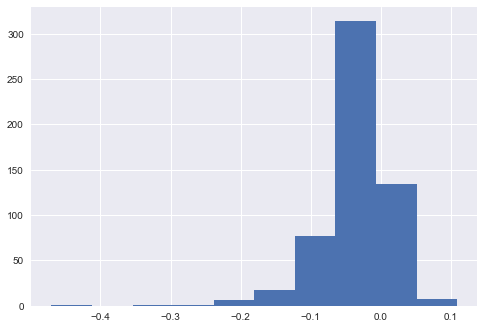

In [41]:
df_combo.cbr_diff.hist()
plt.show()

In [38]:
df_combo[df_combo.cbr_diff<-0.1][['conversation_id','person_type','conversation_added','service_type','status','provider_cbr_all_db','provider_cbr_all_r2b','provider_id']]



,conversation_id,person_type,conversation_added,service_type,status,provider_cbr_all_db,provider_cbr_all_r2b,provider_id
2,10385256,merged,2017-11-28 21:50:21,overnight-traveling,red,0.243182,0.349434,1319607
9,10375310,rover,2017-11-28 05:29:25,doggy-day-care,green,0.372222,0.554000,4716102
10,10380916,migrated,2017-11-28 18:03:17,doggy-day-care,red,0.523636,0.630294,3536647
19,10372765,rover,2017-11-28 02:19:30,drop-in,green,0.362000,0.480000,3850503
20,10378950,rover,2017-11-28 16:13:55,drop-in,red,0.397188,0.520938,3710105
29,10390466,rover,2017-11-29 02:49:11,dog-walking,seeding,0.335000,0.500000,2467295
36,10392338,migrated,2017-11-29 05:18:30,doggy-day-care,green,0.446667,0.556667,3209883
49,10376389,merged,2017-11-28 12:48:35,doggy-day-care,red,0.334911,0.439235,1318592
77,10385221,rover,2017-11-28 21:47:57,dog-walking,green,0.784000,0.990000,4776051
113,10383880,rover,2017-11-28 20:34:14,doggy-day-care,red,0.333860,0.436435,1555762


In [ ]:
import math
st_list = df_combo.service_type.unique()
for i in fea_db:
#     f, ax = plt.subplots(ncols=5, figsize=(24, 5))
#     for k,st in enumerate(st_list):
#         df = df_combo[(df_combo.service_type == st) ]
        j = i.replace('db','r2b')
#         sns.pairplot(data=[[i,j,'matriculation_level']],hue='matriculation_level')
#         max_no = max(df[[i,j]].max()[i],df[[i,j]].max()[j])
#         ax[k].scatter(data=df,x=i,y=j,hue='matriculation_level')
#         ax[k].plot([0,max_no],[0,max_no])
#         cor_text =  str(df[[i,j]].corr().loc[i,j])
#         ax[k].text(0,max_no,cor_text)
        sns.lmplot(x=i, y=j, col='service_type', data=df_combo,hue='matriculation_level_r2b',aspect=0.7,col_wrap=5)
#         display(
#         ax[k].set_title(st)
        plt.suptitle(i.replace('_db',''))
        plt.show()

### Matriculation_level

In [ ]:
df_combo['matri_diff'] =  df_combo.matriculation_level_r2b - df_combo.matriculation_level_db

In [ ]:
df_combo.matri_diff.value_counts()

* matri_diff = 1: this happens when there is a time stamp mismatch 

In [ ]:
df_combo[df_combo['matri_diff'] == 1][['matriculation_level_r2b','status','conversation_id','provider_id','service_type','all_requests_provider','provider_cbr_all_db','provider_cbr_all_r2b']]

## Provider_cbr_all

In [ ]:
df_combo[(df_combo.provider_cbr_all_db > 0) & (df_combo.provider_cbr_all_r2b == 0)] [['service_type','conversation_id','conversation_added','provider_cbr_all_r2b','provider_cbr_all_db','all_requests_provider']]

In [ ]:
df_combo['cbr_diff'] =  df_combo.provider_cbr_all_db/(df_combo.provider_cbr_all_r2b+0.0)

In [ ]:
df_combo[['conversation_id','conversation_added','provider_id','service_type','provider_cbr_all_db','provider_cbr_all_r2b','cbr_diff','all_requests_provider']].sort_values(by='cbr_diff')

In [ ]:
df_combo[(df_combo.provider_cbr_all_r2b > 0) & (df_combo.provider_cbr_all_db == 0)] [['service_type','conversation_id','conversation_added','provider_cbr_all_r2b','provider_cbr_all_db','all_requests_provider']]

## Calendar_recency

In [ ]:
df = df_combo[(df_combo.calendar_recency_r2b == 0) & (df_combo.calendar_recency_db > 1)] [['service_type','conversation_id','provider_id','conversation_added','calendar_recency_db','calendar_recency_r2b',]].sort_values(by = 'provider_id' ,ascending=False)

In [ ]:
'''-- select service_id from conversations_conversation where id = 10339135

select * from conversations_conversation where service_id = 426622

select * from services_service where id = 426622

-- --no_cache
select
  cc.id as conversation_id
  , sh.accepts_more_than_one_client
  , sh.last_updated_calendar
  , sh.spaces_available
  , cc.added as conversation_added
from
  roverdb.conversations_conversation cc
  join(
    select distinct
      original_conversation_id
      , accepts_more_than_one_client
      , last_updated_calendar
      , spaces_available
      , service_id
    from
      roverdb_historical.service_history
    where service_id = 426622 
  )
  sh on
    cc.service_id = sh.service_id and cc.id = sh.original_conversation_id
'''

In [ ]:
df = df_combo[(df_combo.calendar_recency_db == 0) & (df_combo.calendar_recency_r2b > 2)] [['service_type','conversation_id','provider_id','calendar_recency_db','calendar_recency_r2b']].sort_values(by = 'calendar_recency_r2b' ,ascending=False)

In [ ]:
df.count()

In [ ]:
df_combo[(df_combo.provider_cbr_all_db == 0) &(df_combo.provider_cbr_all_r2b>0)][['service_type','conversation_id','provider_id','provider_cbr_all_db','provider_cbr_all_r2b','provider_all_requests','provider_all_bookings']].sort_values(by = 'provider_cbr_all_db',ascending = False )

In [ ]:
df_combo[(df_combo.first_request_db == 0) & (df_combo.first_request_r2b > 0)] [['service_type','conversation_id','first_request_db','first_request_r2b']]

In [ ]:
df_combo[(df_combo.provider_cbr_all_db == 0) & (df_combo.provider_cbr_all_r2b > 0)] [['service_type','conversation_id','provider_id','provider_cbr_all_db','provider_cbr_all_r2b']].sort_values(by = 'provider_cbr_all_r2b',ascending = False )

In [ ]:
list(df_combo)

In [ ]:
df_combo[(df_combo.provider_cbr_all_db > 0) & (df_combo.provider_cbr_all_r2b == 0)] [['service_type','conversation_id','provider_cbr_all_db','all_requests_provider']]

In [ ]:
df_combo[df_combo.service_type == 'overnight_traveling'].spaces_available_db.head()

In [ ]:
df_combo[df_combo.service_type == 'overnight_traveling'].spaces_available_r2b.head()